In [2]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
from tqdm import *
from scipy.integrate import nquad
from scipy.interpolate import interp1d
from scipy.special import erf
import matplotlib.pylab as pylab
from cycler import cycler
import palettable

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from theory.units import *
from theory.spec_calc import PowerSpectra, PowerSpectraPopulations
from theory.astrometry_forecast import Parameter, AstrometryObservation, FisherForecast

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
params = {'text.usetex': True,
          'font.family': 'serif',
          'font.serif': ['CMU Serif'],
          'font.sans-serif': ['CMU Sans Serif'],
          'legend.fontsize': 17,
          'legend.fancybox': True,
          'legend.frameon': False,
          'legend.framealpha': 0.4,
          'legend.labelspacing': 0.5,
          'figure.figsize': (6.4/1.1, 4.8/1.1),
          'axes.labelsize': 19,
          'axes.titlesize':18,
          'axes.titlepad':10,
          'axes.linewidth':1.1,
          'axes.labelpad':10,
          'axes.prop_cycle': cycler('color', palettable.cartocolors.qualitative.Bold_10.hex_colors) + 
                            cycler(alpha=10*[.7]), 
          'lines.linewidth':2.5,
          'xtick.labelsize':18,
          'ytick.labelsize':18,
          'xtick.top':True,
          'ytick.right':True,
          'xtick.direction': 'in',
          'ytick.direction': 'in',
          'xtick.major.size': 5,
          'xtick.minor.size': 2,
          'ytick.major.size': 5,
          'ytick.minor.size': 2,
          'xtick.major.width': 1,
          'ytick.major.width': 1,
          'xtick.minor.width': 0.8,
          'ytick.minor.width': 0.8,
         }
pylab.rcParams.update(params)

In [12]:
plots_dir = "/Users/smsharma/Dropbox/Projects/LensPowerSpectra/LensPower/draft/plots/"

In [7]:
alpha_plot = 0.8
lw_plot = 2.5
colors_plot = ['dodgerblue', 'orange', 'mediumorchid']

In [4]:
pspec = PowerSpectra(precompute=['NFW', 'Burk'])

# Populations

In [17]:
pspecpop = PowerSpectraPopulations()

pspecpop.set_radial_distribution(pspecpop.r2rho_V_ein_EAQ, R_min=1e-2*kpc, R_max=260*kpc)
pspecpop.set_mass_distribution(pspecpop.rho_M_SI, M_min=1e4*M_s, M_max=0.04*1.1e12*M_s, 
                               M_min_calib=1e8*M_s, M_max_calib=1e10*M_s, N_calib=150, alpha=-1.9)
pspecpop.set_subhalo_properties(pspecpop.c200_Moline)

C_l_mu = pspecpop.get_C_l_total_ary();

In [18]:
pspecpop_notidal = PowerSpectraPopulations()

pspecpop_notidal.set_radial_distribution(pspecpop.r2rho_V_NFW, R_min=1e-2*kpc, R_max=260*kpc)
pspecpop_notidal.set_mass_distribution(pspecpop.rho_M_SI, M_min=1e4*M_s, M_max=0.04*1.1e12*M_s, 
                               M_min_calib=1e8*M_s, M_max_calib=1e10*M_s, N_calib=150, alpha=-1.9)
pspecpop_notidal.set_subhalo_properties(pspecpop.c200_SCP)

C_l_mu_notidal = pspecpop_notidal.get_C_l_total_ary();

## Differential Power

### Over masses

In [10]:
logM_min_plot = 6
logM_max_plot = 11.5

M_ary = np.logspace(logM_min_plot,logM_max_plot,100)*M_s

ell = 10
dlogC_l_dM_ary_10 = np.array([pspecpop.dC_l_dM_total(ell, M)/pspecpop.C_l_ary[ell] for M in tqdm_notebook(M_ary)])
ell = 30
dlogC_l_dM_ary_30 = np.array([pspecpop.dC_l_dM_total(ell, M)/pspecpop.C_l_ary[ell] for M in tqdm_notebook(M_ary)])
ell = 100
dlogC_l_dM_ary_100 = np.array([pspecpop.dC_l_dM_total(ell, M)/pspecpop.C_l_ary[ell] for M in tqdm_notebook(M_ary)])

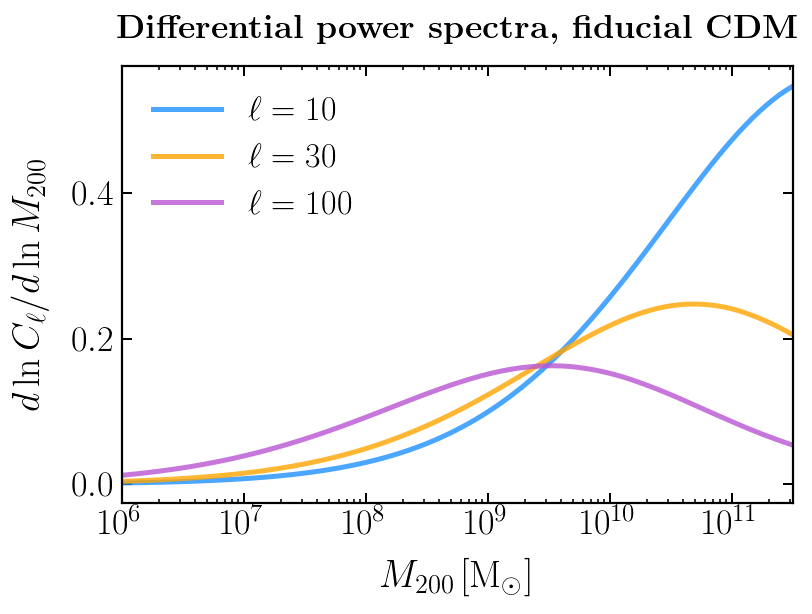

In [13]:
plt.plot(M_ary/M_s, (M_ary/M_s)*dlogC_l_dM_ary_10/(1/M_s),label="$\ell = 10$", alpha=alpha_plot, lw=lw_plot, color=colors_plot[0])
plt.plot(M_ary/M_s, (M_ary/M_s)*dlogC_l_dM_ary_30/(1/M_s),label="$\ell = 30$", alpha=alpha_plot, lw=lw_plot, color=colors_plot[1])
plt.plot(M_ary/M_s, (M_ary/M_s)*dlogC_l_dM_ary_100/(1/M_s),label="$\ell = 100$", alpha=alpha_plot, lw=lw_plot, color=colors_plot[2])

plt.xlabel("$M_{200}$\,[M$_\odot$]")
plt.ylabel("$d\ln C_\ell/d\ln M_{200}$")

plt.xscale("log")

plt.xlim(10**logM_min_plot, 10**logM_max_plot)

plt.legend(frameon=False)

plt.title('\\textbf{Differential power spectra, fiducial CDM}', y = 1.02, fontsize=17)


plt.tight_layout()
plt.savefig(plots_dir + "dlnCldlnM200.pdf")

### Over Galactocentric radii

In [14]:
R_min_plot = 1e-2
R_max_plot = 260

R_ary = np.linspace(R_min_plot, R_max_plot, 100)*kpc

ell = 10
dlogC_l_dR_ary_10 = np.array([pspecpop.dC_l_dR_total(ell, R)/pspecpop.C_l_ary[ell] for R in tqdm_notebook(R_ary)])
ell = 30
dlogC_l_dR_ary_30 = np.array([pspecpop.dC_l_dR_total(ell, R)/pspecpop.C_l_ary[ell] for R in tqdm_notebook(R_ary)])
ell = 100
dlogC_l_dR_ary_100 = np.array([pspecpop.dC_l_dR_total(ell, R)/pspecpop.C_l_ary[ell] for R in tqdm_notebook(R_ary)])

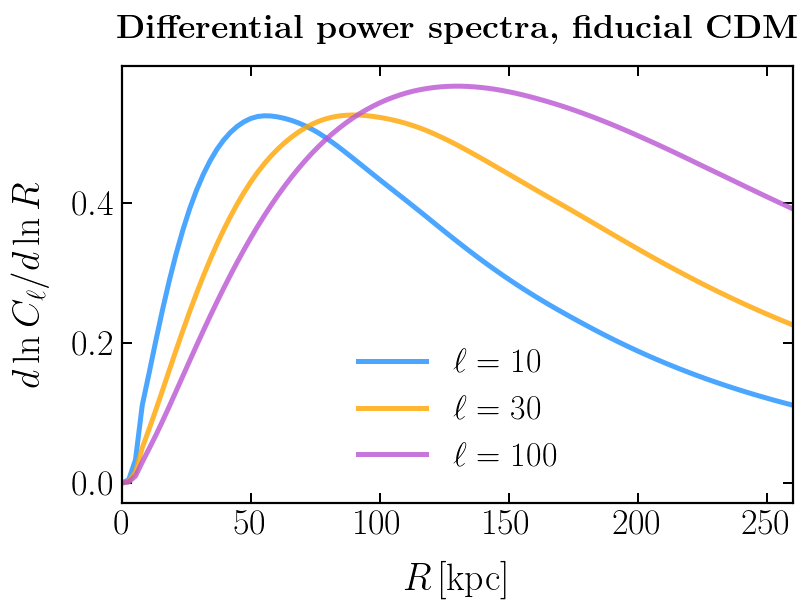

In [15]:
plt.plot(R_ary/kpc, (R_ary/kpc)*dlogC_l_dR_ary_10/(1/kpc),label="$\ell = 10$", alpha=alpha_plot, lw=lw_plot, color=colors_plot[0])
plt.plot(R_ary/kpc, (R_ary/kpc)*dlogC_l_dR_ary_30/(1/kpc),label="$\ell = 30$", alpha=alpha_plot, lw=lw_plot, color=colors_plot[1])
plt.plot(R_ary/kpc, (R_ary/kpc)*dlogC_l_dR_ary_100/(1/kpc),label="$\ell = 100$", alpha=alpha_plot, lw=lw_plot, color=colors_plot[2])

plt.xlabel("$R$\,[kpc]")
plt.ylabel("$d\ln C_\ell/d\ln R$")

plt.xlim(R_min_plot, R_max_plot)

plt.legend(frameon=False)

plt.title('\\textbf{Differential power spectra, fiducial CDM}', y = 1.02, fontsize=17)

plt.tight_layout()
plt.savefig(plots_dir + "dlnCldlnR.pdf")

## Total signal and noise power spectrum

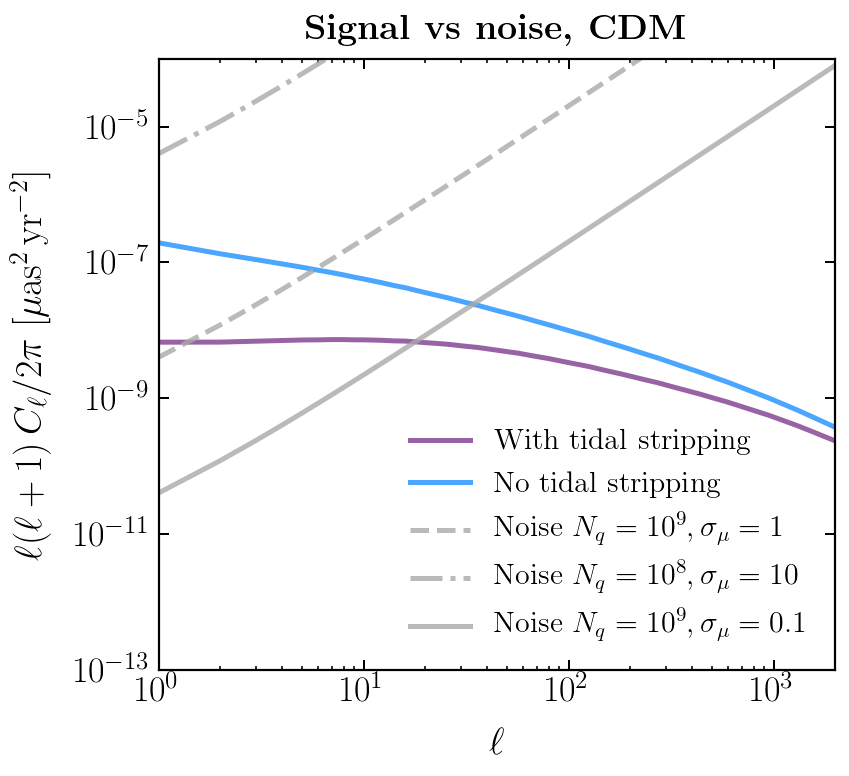

In [24]:
rcParams['figure.figsize'] = 6, 5.5

plt.plot(pspecpop.l_ary, (1/(2*np.pi))*pspecpop.l_ary*(pspecpop.l_ary + 1)*C_l_mu, label="With tidal stripping", alpha=alpha_plot, lw=lw_plot)
plt.plot(pspecpop.l_ary, (1/(2*np.pi))*pspecpop.l_ary*(pspecpop.l_ary + 1)*C_l_mu_notidal, label="No tidal stripping", alpha=alpha_plot, lw=lw_plot, color=colors_plot[0])

sigma_mu = 1
sigma_alpha = .1
N_q = 1e9

plt.plot(pspecpop.l_ary, (1/(2*np.pi))*pspecpop.l_ary*(pspecpop.l_ary + 1)*np.ones_like(pspecpop.l_ary)*4*np.pi*sigma_mu**2/N_q, label="Noise $N_q = 10^9, \sigma_\mu=1$", alpha=alpha_plot, lw=lw_plot, color='darkgrey', ls='--')

sigma_mu = 10
sigma_alpha = .1
N_q = 1e8

plt.plot(pspecpop.l_ary, (1/(2*np.pi))*pspecpop.l_ary*(pspecpop.l_ary + 1)*np.ones_like(pspecpop.l_ary)*4*np.pi*sigma_mu**2/N_q, label="Noise $N_q = 10^8, \sigma_\mu=10$", alpha=alpha_plot, lw=lw_plot, color='darkgrey', ls='-.')

sigma_mu = 0.1
sigma_alpha = .1
N_q = 1e9

plt.plot(pspecpop.l_ary, (1/(2*np.pi))*pspecpop.l_ary*(pspecpop.l_ary + 1)*np.ones_like(pspecpop.l_ary)*4*np.pi*sigma_mu**2/N_q, label="Noise $N_q = 10^9, \sigma_\mu=0.1$", alpha=alpha_plot, lw=lw_plot, color='darkgrey', ls='-')

plt.yscale("log")
plt.xscale("log")

plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)\,C_\ell/2\pi$ [$\mu$as$^2$\,yr$^{-2}$]")

plt.xlim(1, 2000)
plt.ylim(1e-13,1e-4)

plt.legend(frameon=False, ncol=1, fontsize=15, loc='lower right')

plt.title('\\textbf{Signal vs noise, CDM}', fontsize=18)

plt.tight_layout()
plt.savefig(plots_dir + "LCDMTheoryNoise.pdf")

# Fisher Forecasts

In [25]:
# Test

sigma_mu = 1
sigma_alpha = .1
N_q = 1e8

fDM_base = 1
dfDM_base = 0.1

Cl_ary_fid = pspecpop.C_l_ary*fDM_base

p = pspecpop.C_l_ary*(fDM_base + dfDM_base)
m = pspecpop.C_l_ary*(fDM_base - dfDM_base)

fDM = Parameter('fDM', fDM_base ,dfDM_base ,None, True, p, m, 
                None, None, '$\\f_\mathrm{DM}$' )

parameters = [Cl_ary_fid, None, 1, 2000, fDM]
observation = AstrometryObservation(fsky=1, sigma_mu=sigma_mu, sigma_alpha=None, N_q=N_q, l_min_mu=5, l_max_mu=300, l_min_alpha=2, l_max_alpha=2000)

fshr = FisherForecast(parameters, observation)
lim = 1.64*np.sqrt(np.linalg.inv(fshr.fshr_cls + fshr.fshr_prior)[0,0])
print(lim)
baseline_sig = fDM_base/fshr.pars_vary[0].sigma
print(baseline_sig)

32.87631347147505
0.049883938520751014


## LCDM discovery significance

In [26]:
sigma_mu_ary = np.logspace(-2,1,50)
N_q_ary = np.logspace(6,9,50)

In [27]:
sig_ary = np.zeros((len(sigma_mu_ary), len(N_q_ary)))
lim_ary = np.zeros((len(sigma_mu_ary), len(N_q_ary)))

for isigmu, sigmu in enumerate(tqdm_notebook(sigma_mu_ary)):
    for iNq, Nq in enumerate(N_q_ary):
        
        fDM_base = 1
        dfDM_base = 0.1

        Cl_ary_fid = C_l_mu*fDM_base

        p = C_l_mu*(fDM_base + dfDM_base)
        m = C_l_mu*(fDM_base - dfDM_base)

        fDM = Parameter('fDM', fDM_base ,dfDM_base ,None, True, p, m, 
                        None, None, '$\\f_\mathrm{DM}$' )

        parameters = [Cl_ary_fid, None, 1, 2000, fDM]
        observation = AstrometryObservation(fsky=1, sigma_mu=sigmu, sigma_alpha=None, N_q=Nq, l_min_mu=2, l_max_mu=2000, l_min_alpha=2, l_max_alpha=2000)

        fshr = FisherForecast(parameters, observation)
        lim = 1.64*np.sqrt(np.linalg.inv(fshr.fshr_cls + fshr.fshr_prior)[0,0])
        sig_ary[isigmu, iNq] = fDM_base/fshr.pars_vary[0].sigma
        lim_ary[isigmu, iNq] = lim


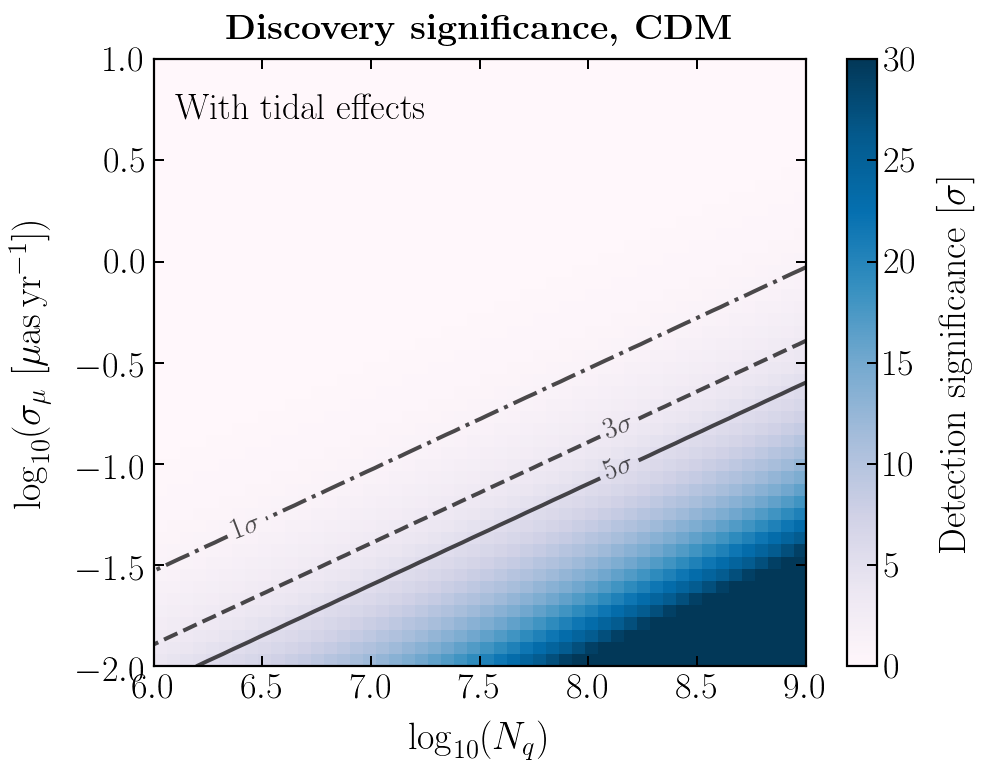

In [32]:
rcParams['figure.figsize'] = 7, 5.5

levels = [1,3,5]
X, Y = np.meshgrid(np.log10(N_q_ary), np.log10(sigma_mu_ary))

fig, ax = plt.subplots()

CS = ax.contour(X, Y, sig_ary, levels = levels, linestyles=['-.','--','-'], colors='k', linewidths=2, alpha=0.7)

fmt = {}
strs = ['1$\sigma$', '3$\sigma$', '5$\sigma$']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
    
im = ax.imshow(sig_ary,cmap = 'PuBu', aspect='auto', origin='lower', extent=[6,9,-2,1], vmin=0, vmax=30)

ax.clabel(CS, fmt=fmt,inline=1, fontsize=14)

ax.set_xlabel("$\log_{10}(N_q)$")
ax.set_ylabel("$\log_{10}(\sigma_\mu~[\mu$as\,yr$^{-1}$])")
ax.set_title('\\textbf{Discovery significance, CDM}', fontsize=18)

ax.text(6.1, 0.7, "With tidal effects", fontsize=18)

cbar = fig.colorbar(im)
cbar.set_label('Detection significance [$\sigma$]')

plt.tight_layout()
plt.savefig(plots_dir + "LCDM_disc.pdf")

In [33]:
sig_ary_notidal = np.zeros((len(sigma_mu_ary), len(N_q_ary)))
lim_ary_notidal = np.zeros((len(sigma_mu_ary), len(N_q_ary)))

for isigmu, sigmu in enumerate(tqdm_notebook(sigma_mu_ary)):
    for iNq, Nq in enumerate(N_q_ary):
        
        fDM_base = 1
        dfDM_base = 0.1

        Cl_ary_fid = C_l_mu*fDM_base

        p = C_l_mu_notidal*(fDM_base + dfDM_base)
        m = C_l_mu_notidal*(fDM_base - dfDM_base)

        fDM = Parameter('fDM', fDM_base ,dfDM_base ,None, True, p, m, 
                        None, None, '$\\f_\mathrm{DM}$' )

        parameters = [Cl_ary_fid, None, 1, 2000, fDM]
        observation = AstrometryObservation(fsky=1, sigma_mu=sigmu, sigma_alpha=None, N_q=Nq, l_min_mu=2, l_max_mu=2000, l_min_alpha=2, l_max_alpha=2000)

        fshr = FisherForecast(parameters, observation)
        lim = 1.64*np.sqrt(np.linalg.inv(fshr.fshr_cls + fshr.fshr_prior)[0,0])
        sig_ary_notidal[isigmu, iNq] = fDM_base/fshr.pars_vary[0].sigma
        lim_ary_notidal[isigmu, iNq] = lim


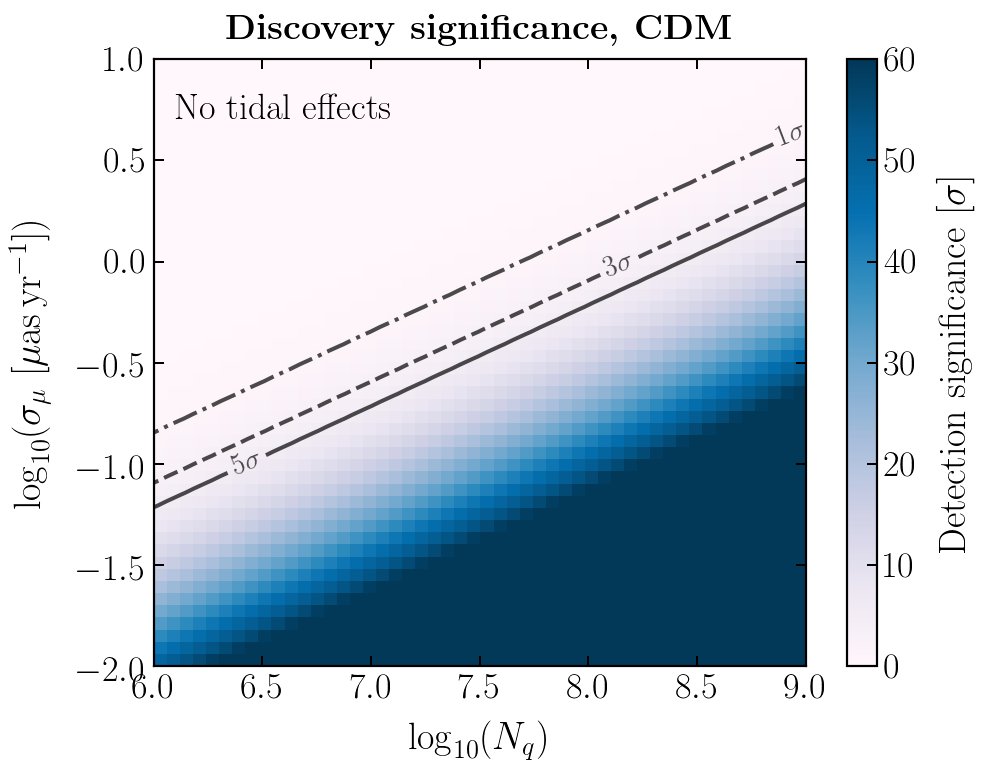

In [36]:
rcParams['figure.figsize'] = 7, 5.5

levels = [1,3,5]
X, Y = np.meshgrid(np.log10(N_q_ary), np.log10(sigma_mu_ary))

fig, ax = plt.subplots()

CS = ax.contour(X, Y, sig_ary_notidal, levels = levels, linestyles=['-.','--','-'], colors='k', linewidths=2, alpha=0.7)

fmt = {}
strs = ['1$\sigma$', '3$\sigma$', '5$\sigma$']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
    
im = ax.imshow(sig_ary_notidal,cmap = 'PuBu', aspect='auto', origin='lower', extent=[6,9,-2,1], vmin=0, vmax=60)

ax.clabel(CS, fmt=fmt,inline=1, fontsize=14)

ax.set_xlabel("$\log_{10}(N_q)$")
ax.set_ylabel("$\log_{10}(\sigma_\mu~[\mu$as\,yr$^{-1}$])")
ax.set_title('\\textbf{Discovery significance, CDM}', fontsize=18)

ax.text(6.1, 0.7, "No tidal effects", fontsize=18)

cbar = fig.colorbar(im)
cbar.set_label('Detection significance [$\sigma$]')

plt.tight_layout()
plt.savefig(plots_dir + "LCDM_disc_notidal.pdf")
